# Pendulum Deep Ensemble

## The dataset: simple static pendulum
Using the position of a pendulum at one point in time from a collection of pendulums on two different planets, determine the position associated with L, $\theta$, and $a_g$ using a deep ensemble. Additionally, predict $\sigma$, which is the error introduced.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

In [2]:
## first, import all the necessary modules
import arviz as az
import corner
import graphviz
import jax
from jax import random
import jax.numpy as jnp # yes i know this is confusing
import matplotlib.pyplot as plt
import numpy as np
import numpyro

## in numpyro, you must specify number of sampling chains you will use upfront

# words of wisdom from Tian Li and crew:
# on gpu, don't use conda, use pip install
# HMC after SBI to look at degeneracies between params
# different guides (some are slower but better at showing degeneracies)

## define the platform and number of cores (one chain per core)
numpyro.set_platform('cpu')
core_num = 4
numpyro.set_host_device_count(core_num)

import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
import pandas as pd
from sklearn.preprocessing import LabelEncoder

In [3]:
import sys
sys.path.append('..')
from src.scripts import train, models, analysis

In [4]:
loss_type = 'var_loss'
# options are 'no_var_loss' or 'var_loss'

## Generate pendulum data
To do this make a dataframe and replicate a bunch of columns. There are 8 pendulums on two different planets. The planet_id and pendulum_id are integers denoting which pendulum and which planet each row of the dataframe belongs.

[0.         0.02020202 0.04040404 0.06060606 0.08080808 0.1010101
 0.12121212 0.14141414 0.16161616 0.18181818 0.2020202  0.22222222
 0.24242424 0.26262626 0.28282828 0.3030303  0.32323232 0.34343434
 0.36363636 0.38383838 0.4040404  0.42424242 0.44444444 0.46464646
 0.48484848 0.50505051 0.52525253 0.54545455 0.56565657 0.58585859
 0.60606061 0.62626263 0.64646465 0.66666667 0.68686869 0.70707071
 0.72727273 0.74747475 0.76767677 0.78787879 0.80808081 0.82828283
 0.84848485 0.86868687 0.88888889 0.90909091 0.92929293 0.94949495
 0.96969697 0.98989899 1.01010101 1.03030303 1.05050505 1.07070707
 1.09090909 1.11111111 1.13131313 1.15151515 1.17171717 1.19191919
 1.21212121 1.23232323 1.25252525 1.27272727 1.29292929 1.31313131
 1.33333333 1.35353535 1.37373737 1.39393939 1.41414141 1.43434343
 1.45454545 1.47474747 1.49494949 1.51515152 1.53535354 1.55555556
 1.57575758 1.5959596  1.61616162 1.63636364 1.65656566 1.67676768
 1.6969697  1.71717172 1.73737374 1.75757576 1.77777778 1.79797

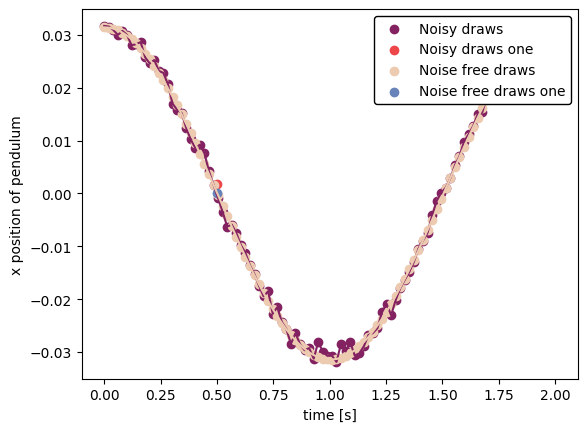

[0.03167618890732235, 0.03156051750502359, 0.030914934835051748, 0.0299767778689179, 0.0307368919133213, 0.02999183853166963, 0.02803405284709038, 0.02821957681680757, 0.0286223334446088, 0.02573499238700816, 0.02459159570518019, 0.025226483314264445, 0.023174071513404493, 0.02278621012444748, 0.020629708936078968, 0.016999123544670813, 0.015816641471014675, 0.01519897835662003, 0.012413306503932629, 0.01020623112517607, 0.008608786892870696, 0.009213287470802613, 0.007612474184328847, 0.004199965797240971, 0.0016819662896942467, -0.0009141776381478535, -0.0034619362051676555, -0.006272926348039236, -0.005891295967577684, -0.0074681186853430385, -0.009747104988890767, -0.01124641306015731, -0.013596051034927479, -0.01530086725980894, -0.017480068594479963, -0.019455836760831933, -0.018494323987091093, -0.02273893071536812, -0.021502845350623398, -0.024309610338425672, -0.025650913736130244, -0.028435744580136712, -0.026426297029663304, -0.028531310567578985, -0.029645493473853396, -0.0

In [5]:
import deepbench
from deepbench.physics_object import Pendulum

true_L = 1.0
true_theta = np.pi / 100
true_a = 9.8
percent_error = 0.1
dL = percent_error * true_L

pendulum = Pendulum(
            pendulum_arm_length=true_L,
            starting_angle_radians=true_theta,
            acceleration_due_to_gravity=true_a,
            noise_std_percent={
                "pendulum_arm_length": percent_error,
                "starting_angle_radians": 0.0,
                "acceleration_due_to_gravity": 0.0,
            },
        )

time = np.linspace(0,2,100)
print(time)
one_time = 0.5

pendulum_noiseless = pendulum.create_object(time, noiseless=True)
# for every moment in time
true_sigma = 0.001
pendulum_noisy = []
for p in pendulum_noiseless:
    rs = np.random.RandomState()#2147483648)# 
    attribute = rs.normal(loc=0, scale=true_sigma)
    pendulum_noisy.append(p + attribute)

'''
for r in range(100):
    rs = np.random.RandomState()#2147483648)# 
    attribute = rs.normal(loc=0, scale=1)
    #print('random number', attribute)
    plt.scatter(one_time, attribute * dx_dtheta_0 + pendulum_noiseless_one, color = 'red', s= 0.1)#, label = 'Expected error plus gaussian random noise')

'''

pendulum_noisy_one = pendulum.create_object(one_time, noiseless=False)
pendulum_noiseless_one = pendulum.create_object(one_time, noiseless=True)
rs = np.random.RandomState()#2147483648)# 
attribute = rs.normal(loc=0, scale=true_sigma)
pendulum_noisy_one = pendulum_noiseless_one + attribute


plt.clf()
plt.plot(time, pendulum_noisy, color = '#832161')
plt.scatter(time, pendulum_noisy, label = 'Noisy draws', color = '#832161')
plt.scatter(one_time, pendulum_noisy_one, label = 'Noisy draws one', color = '#ED474A')
plt.plot(time, pendulum_noiseless, color = '#EDCBB1')
plt.scatter(time, pendulum_noiseless, label = 'Noise free draws', 
            color = '#EDCBB1')
plt.scatter(one_time, pendulum_noiseless_one, label = 'Noise free draws one', 
            color = '#6883BA')
legend = plt.legend(loc="upper right", edgecolor="black")
legend.get_frame().set_alpha(1.0)
plt.xlabel('time [s]')
plt.ylabel('x position of pendulum')
plt.show()

print(pendulum_noisy)
print(pendulum_noiseless)


In [6]:
# okay now make a dataframe with a bunch of different options for the parameters
# generate the L, theta, a_g values somewhat randomly between ranges
length_percent_error_all = 0.0
theta_percent_error_all = 0.0 # was 0.1
a_g_percent_error_all = 0.0
pos_err = 0.0

time = 0.5

length_df = 1000
ys = np.zeros((length_df, 4))
x_noisy = []
#true_sigmas = []

for r in range(length_df):
    rs = np.random.RandomState()#2147483648)# 
    length = abs(rs.normal(loc=5, scale=1))
    theta = abs(rs.normal(loc=jnp.pi/100, scale=jnp.pi/200))
    a_g = abs(rs.normal(loc=10, scale=2))
    epsilon = rs.normal(loc=0, scale=true_sigma)
    ys[r,:] = [length, theta, a_g, epsilon]
    
    pendulum = Pendulum(
        pendulum_arm_length=length,
        starting_angle_radians=theta,
        acceleration_due_to_gravity=a_g,
        noise_std_percent={
            "pendulum_arm_length": length_percent_error_all,
            "starting_angle_radians": theta_percent_error_all,
            "acceleration_due_to_gravity": a_g_percent_error_all,
        },
    )
    
    #true_sigmas.append(attribute)
    x_noisy.append(pendulum.create_object(time, noiseless=True) + epsilon)
    del pendulum

<Figure size 640x480 with 0 Axes>

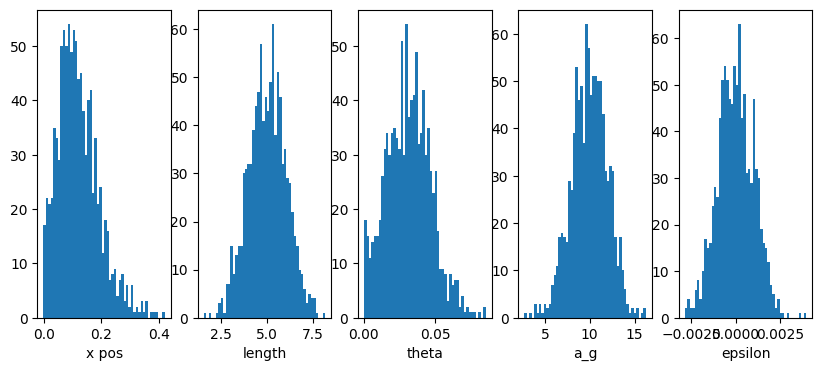

In [7]:
plt.clf()
fig = plt.figure(figsize = (10,4))
ax = fig.add_subplot(151)
ax.hist(x_noisy, bins=50)
ax.set_xlabel('x pos')
ax1 = fig.add_subplot(152)
ax1.hist(ys[:,0], bins=50)
ax1.set_xlabel('length')
ax2 = fig.add_subplot(153)
ax2.hist(ys[:,1], bins=50)
ax2.set_xlabel('theta')
ax3 = fig.add_subplot(154)
ax3.hist(ys[:,2], bins=50)
ax3.set_xlabel('a_g')
ax4 = fig.add_subplot(155)
ax4.hist(ys[:,3], bins=50)
ax4.set_xlabel('epsilon')
plt.show()

In [8]:
# we need to normalize everything
xmin = np.min(x_noisy)#, axis = 0)
xmax = np.max(x_noisy)#, axis = 0)
ymin = np.min(ys, axis = 0)
ymax = np.max(ys, axis = 0)

norm_xs = (x_noisy - xmin) / (xmax - xmin)
# normal_value = (og_value - xmin) / (xmax - xmin)
# og_value = normal_value * (xmax - xmin) + xmin
norm_ys = (ys - ymin) / (ymax - ymin)

(900,) (900, 4)
()


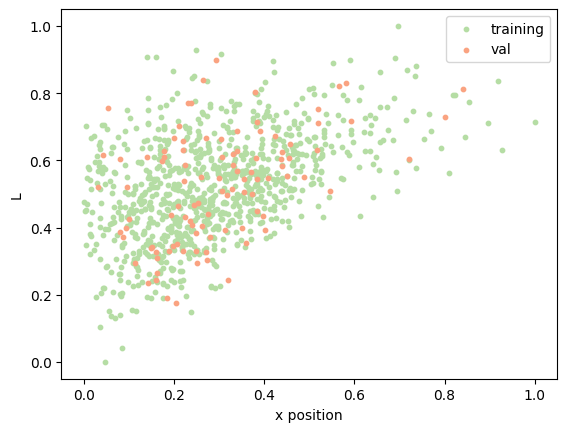

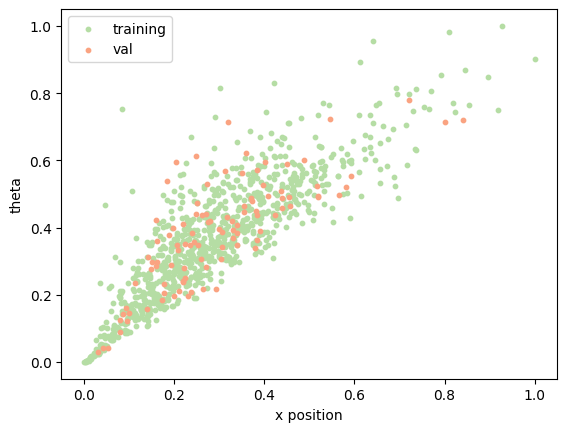

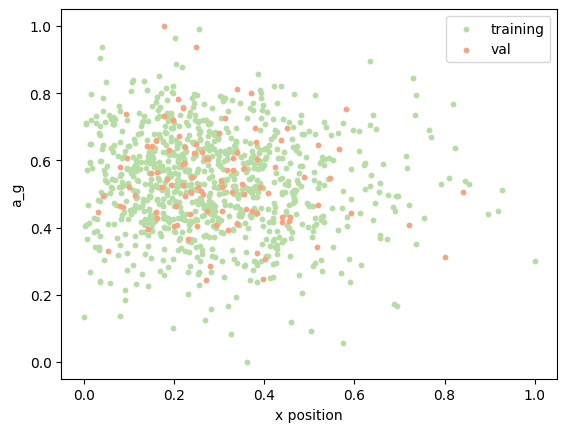

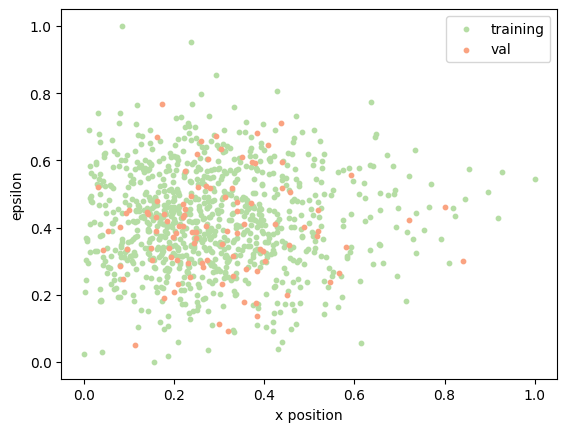

'\nSTOP\n#\n\nscaler = StandardScaler()\nscaler.fit(data)\nStandardScaler()\n>>> print(scaler.mean_)\n[0.5 0.5]\n>>> print(scaler.transform(data))\n\nx_scaler, x_train, x_val = StandardScaler(x_train, x_val)\ny_scaler, y_train, y_val = StandardScaler(y_train, y_val)\n'

In [9]:
# prepare the training, validation, and test set split:

val_proportion = 0.1
x_train, x_val, y_train, y_val = train_test_split(norm_xs, norm_ys, test_size=val_proportion, random_state=42)

print(np.shape(x_train), np.shape(y_train))
print(np.shape(x_train[:][0]))


plt.clf()
plt.scatter(x_train, y_train[:,0], label = 'training', color = '#B5DDA4', s = 10)
plt.scatter(x_val, y_val[:,0], label = 'val', color = '#FAA381', s = 10)
plt.legend()
plt.xlabel('x position')
plt.ylabel('L')
plt.show()

plt.clf()
plt.scatter(x_train, y_train[:,1], label = 'training', color = '#B5DDA4', s = 10)
plt.scatter(x_val, y_val[:,1], label = 'val', color = '#FAA381', s = 10)
plt.legend()
plt.xlabel('x position')
plt.ylabel('theta')
plt.show()

plt.clf()
plt.scatter(x_train, y_train[:,2], label = 'training', color = '#B5DDA4', s = 10)
plt.scatter(x_val, y_val[:,2], label = 'val', color = '#FAA381', s = 10)
plt.legend()
plt.xlabel('x position')
plt.ylabel('a_g')
plt.show()

plt.clf()
plt.scatter(x_train, y_train[:,3], label = 'training', color = '#B5DDA4', s = 10)
plt.scatter(x_val, y_val[:,3], label = 'val', color = '#FAA381', s = 10)
plt.legend()
plt.xlabel('x position')
plt.ylabel('epsilon')
plt.show()



'''
STOP
#

scaler = StandardScaler()
scaler.fit(data)
StandardScaler()
>>> print(scaler.mean_)
[0.5 0.5]
>>> print(scaler.transform(data))

x_scaler, x_train, x_val = StandardScaler(x_train, x_val)
y_scaler, y_train, y_val = StandardScaler(y_train, y_val)
'''

In [10]:
# okay now train the thing
BATCH_SIZE = 128

# add a dimension so that xs have a one channel input
x_train = x_train.reshape(x_train.shape[0], 1) # 1 was the middle dimension
x_val = x_val.reshape(x_val.shape[0], 1)

'''
print('y', np.shape(y_train))
print('x', np.shape(x_train))
STOP
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1]) # 1 was the middle dimension
x_val = x_val.reshape(x_val.shape[0], x_val.shape[1])
#x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1], x_test.shape[1])
'''

trainData = TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))
trainDataLoader = DataLoader(trainData, batch_size=BATCH_SIZE, shuffle=True)

valData = TensorDataset(torch.Tensor(x_val), torch.Tensor(y_val))
valDataLoader = DataLoader(valData, batch_size=BATCH_SIZE)

# calculate steps per epoch for training and validation set
trainSteps = len(trainDataLoader.dataset) // BATCH_SIZE
valSteps = len(valDataLoader.dataset) // BATCH_SIZE

print('shape of training set', np.shape(x_train))

shape of training set (900, 1)


In [11]:
# initialize the simple model
INIT_LR = 0.001
print("[INFO] initializing the gal model...")
# set the device we will be using to train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


if loss_type == 'no_var_loss':
    model = models.de_no_var().to(device)
    # initialize our optimizer and loss function
    opt = torch.optim.Adam(model.parameters(), lr=INIT_LR)
    lossFn = torch.nn.MSELoss(reduction="mean")
else:
    model = models.de_var().to(device)
    # initialize our optimizer and loss function
    opt = torch.optim.Adam(model.parameters(), lr=INIT_LR)
    lossFn = torch.nn.GaussianNLLLoss(full=False, eps=1e-06, reduction="mean")
#nn.MSELoss(reduction = "mean")

[INFO] initializing the gal model...


In [12]:
print(model)

de_var(
  (ln_1): Linear(in_features=1, out_features=100, bias=True)
  (act1): ReLU()
  (drop1): Dropout(p=0.1, inplace=False)
  (ln_2): Linear(in_features=100, out_features=100, bias=True)
  (act2): ReLU()
  (drop2): Dropout(p=0.1, inplace=False)
  (ln_3): Linear(in_features=100, out_features=100, bias=True)
  (act3): ReLU()
  (drop3): Dropout(p=0.1, inplace=False)
  (ln_4): Linear(in_features=100, out_features=8, bias=True)
)


In [15]:
# plot what we're trying to predict
counter = 0
for (x, y) in trainDataLoader: # loading it up in batches
    #print('batch', counter, 'length', len(y))
    # send the input to the device
    (x, y) = (x.to(device), y.to(device))
    print('x shape', np.shape(x), 'y shape', np.shape(y))
    pred_tensor = model(x)
    pred = pred_tensor.detach().numpy()
    #print(y.shape, pred.shape)
    print(pred.shape, pred)
    print(pred[0])
    STOP
    if loss_type == 'no_var_loss':
        print(np.shape(y), np.shape(pred))
        plt.scatter(y, pred, linestyle='None')
        #var = torch.ones(5, 1, requires_grad=True)  # homoscedastic
        #print('var', pred[:,1])
        loss = lossFn(pred_tensor, y)
        #print('loss', loss.item())
    else:
        plt.errorbar(y, pred[:,0], yerr = abs(pred[:,1]), linestyle='None')
        plt.scatter(y, pred[:,0], linestyle='None')
        #var = torch.ones(5, 1, requires_grad=True)  # homoscedastic
        #print('var', pred[:,1])
        loss = lossFn(pred_tensor[:,0], y, pred_tensor[:,1]**2)
        #print('loss', loss.item())
    
    counter += 1
plt.xlabel('predicted')
plt.ylabel('true')
#plt.xlim([0,1])
#plt.ylim([0,1])
plt.show()
# Interesting, before the model is trained it basically predicts the mean?

x shape torch.Size([128, 1]) y shape torch.Size([128, 4])
(128, 8) [[-0.02772485 -0.08890747 -0.0154821  ...  0.08707614  0.06572384
  -0.10232025]
 [-0.0522294  -0.0626038  -0.00261279 ...  0.08459719  0.04391338
  -0.05505123]
 [ 0.0139922  -0.05370104  0.03872569 ...  0.04672372  0.03261353
  -0.08887509]
 ...
 [ 0.00820861 -0.07527636  0.07742697 ...  0.05502771  0.03627565
  -0.11756825]
 [-0.0374217  -0.06834362  0.00918444 ...  0.07498102  0.03289523
  -0.11686581]
 [ 0.01488863 -0.06754176  0.03130447 ...  0.04282799 -0.0248836
  -0.07188389]]
[-0.02772485 -0.08890747 -0.0154821   0.06681743  0.0697344   0.08707614
  0.06572384 -0.10232025]


NameError: name 'STOP' is not defined

In [ ]:
n_models = 10
model_ensemble = train.train_DE(trainDataLoader,
             x_val,
             y_val,
             INIT_LR,
             device,
             loss_type,
             n_models,
             model_name='DE',
             EPOCHS=40,
             save_checkpoints=False,
             plot=False)
 

In [ ]:
# plot the "posterior" plot, which is gonna be a Gaussian
# for each individual data point
print(np.shape(x_val), np.shape(y_val))
print(x_val[0], y_val[0])
# is there a way to convert x_val[0][3] back to its true value?
# og_value = normal_value * (xmax - xmin) + xmin
og_xval = x_val[0] * (xmax - xmin) + xmin
print('og_xval', og_xval)
og_yval = y_val[0] * (ymax - ymin) + ymin
print('og_yval', og_yval)
STOP
color_list = ['#C7F2A7','#FF8360','#C7F2A7','#FF8360','#C7F2A7','#FF8360','#C7F2A7','#FF8360','#C7F2A7','#FF8360']

for m in range(n_models):
    model = model_ensemble[m]
    model.eval()
    y_pred = model(torch.Tensor(x_val[0]))
    print(y_pred)
    STOP
    y_pred_list.append(y_pred[:,0].detach().numpy())
    

In [ ]:
# there's gotta be a good way to plot the x and the y
plt.clf()

color_list = ['#C7F2A7','#FF8360','#C7F2A7','#FF8360','#C7F2A7','#FF8360','#C7F2A7','#FF8360','#C7F2A7','#FF8360']
y_pred_list = []
for m in range(n_models):
    print(m)
    
        
    
    model = model_ensemble[m]
    model.eval()
    y_pred = model(torch.Tensor(x_val))
    y_pred_list.append(y_pred[:,0].detach().numpy())
    if m > 0:
        continue

    if loss_type == 'no_var_loss':
        plt.scatter(x_val[:,1], y_pred.detach().numpy(),
                label = 'predicted', s = 10, color = 'black')#color = color_list[m],
    else:
        plt.scatter(x_val[:,1], y_pred[:,0].detach().numpy(),
                label = f'predicted model {m}', color = 'black', ls = 'None')#color = color_list[m],
        plt.errorbar(x_val[:,1], y_pred[:,0].detach().numpy(),
                     yerr = abs(y_pred[:,1].detach().numpy()),
                label = f'predicted var model {m}', color = 'black', ls = 'None')#color = color_list[m],
    
dx_dtheta = analysis.calc_error_prop(x_val[:,0], x_val[:,1], x_val[:,2], 0.1, time = 0.5, wrt = 'theta_0')
#print(dx_dtheta)
plt.scatter(x_val[:,1], y_val, label = 'actual', color = 'red', s = 10)
plt.errorbar(x_val[:,1], y_val, yerr = dx_dtheta, label = 'actual', color = 'red', ls = 'None')

plt.xlabel('theta')
plt.ylabel('x pos')
plt.legend()
plt.show()

## Now epistemic error

In [ ]:
#print(y_pred_list)
#print(np.mean(y_pred_list, axis = 0))

plt.clf()
plt.scatter(x_val[:,1], np.mean(y_pred_list, axis = 0), label = 'predicted mean', color = 'black')
plt.errorbar(x_val[:,1], np.mean(y_pred_list, axis = 0),
             yerr = np.std(y_pred_list, axis = 0),
             label = 'predicted std', color = 'black',
             ls = 'None')
dx_dtheta = analysis.calc_error_prop(x_val[:,0], x_val[:,1], x_val[:,2], 0.1, time = 0.5, wrt = 'theta_0')
#print(dx_dtheta)
plt.scatter(x_val[:,1], y_val, label = 'actual', color = 'red', s = 10)
plt.errorbar(x_val[:,1], y_val, yerr = dx_dtheta, label = 'actual analytic expectation', color = 'red', ls = 'None')
plt.xlabel('theta')
plt.ylabel('x pos')
plt.legend()
plt.show()

In [ ]:
plt.clf()
plt.scatter(x_val[:,3], np.mean(y_pred_list, axis = 0), label = 'predicted mean', color = 'black')
plt.errorbar(x_val[:,3], np.mean(y_pred_list, axis = 0),
             yerr = np.std(y_pred_list, axis = 0),
             label = 'predicted std', color = 'black',
             ls = 'None')
plt.scatter(x_val[:,3], y_val, label = 'actual', color = 'red', s = 10)
#plt.errorbar(x_val[:,3], y_val, yerr = dx_dtheta, label = 'actual analytic expectation', color = 'red', ls = 'None')
plt.xlabel('epsilon')
plt.ylabel('x pos')
plt.legend()
plt.show()

In [ ]:
# there's gotta be a good way to plot the x and the y
plt.clf()

y_pred_list_array = np.zeros((np.shape(x_val)[0], n_models))
for m in range(n_models):
    model = model_ensemble[m]
    model.eval()
    y_pred = model(torch.Tensor(x_val))
    y_pred_list_array[:,m] = y_pred.detach().numpy().flatten()

sort_indices = np.argsort(x_val[:, 1])
x_val_sorted = x_val[sort_indices]
y_pred_list_sorted = y_pred_list_array[sort_indices]    
medians = np.median(y_pred_list_sorted, axis = 1).flatten()
mins = np.min(y_pred_list_sorted, axis = 1).flatten()
maxes = np.max(y_pred_list_sorted, axis = 1).flatten()

#plt.fill_between(x_val_sorted[:,1],
#                 mins,
#                 maxes,
#                 label = 'predicted')#color = color_list[m],
plt.errorbar(x_val_sorted[:,1], medians,
             yerr = [medians - mins,maxes - medians], linestyle = 'None', capsize = 5, color = 'black')

plt.scatter(x_val[:,1], y_val, label = 'actual', color = 'red', s = 10)

plt.xlabel('theta')
plt.ylabel('x pos')
plt.legend()
plt.show()

In [ ]:
# also go through and plot the error prop uncertainty given x_val
plt.clf()



y_pred_list_array = np.zeros((np.shape(x_val)[0], n_models))
for m in range(n_models):
    model = model_ensemble[m]
    model.eval()
    y_pred = model(torch.Tensor(x_val))
    y_pred_list_array[:,m] = y_pred.detach().numpy().flatten()

sort_indices = np.argsort(x_val[:, 1])
x_val_sorted = x_val[sort_indices]
y_pred_list_sorted = y_pred_list_array[sort_indices]    
medians = np.median(y_pred_list_sorted, axis = 1).flatten()
mins = np.min(y_pred_list_sorted, axis = 1).flatten()
maxes = np.max(y_pred_list_sorted, axis = 1).flatten()

#plt.fill_between(x_val_sorted[:,1],
#                 mins,
#                 maxes,
#                 label = 'predicted')#color = color_list[m],
plt.errorbar(x_val_sorted[:,1], medians,
             yerr = [medians - mins,maxes - medians], linestyle = 'None', capsize = 5, color = 'black',
             label = 'prediction')

plt.scatter(x_val[:,1], y_val, label = 'actual', color = 'red', s = 10)
plt.errorbar(x_val[:,1], y_val,
             yerr = calc_error_prop(x_val[:,0], x_val[:,1], x_val[:,2], percent_error * x_val[:,1], time = 0.5, wrt = 'theta_0'),
             color = 'red', ls = 'None', capsize = 5)


plt.xlabel('theta')
plt.ylabel('x pos')
plt.legend()
plt.show()

In [ ]:
analysis.calc_error_prop(x_val[:,0], x_val[:,1], x_val[:,2], percent_error * x_val[:,1], time = 0.5, wrt = 'theta_0')